# Challenge: Iterate and evaluate your classifier.

It's time to revisit your classifier from the previous assignment. Using the evaluation techniques we've covered here, look at your classifier's performance in more detail. Then go back and iterate by engineering new features, removing poor features, or tuning parameters. Repeat this process until you have five different versions of your classifier. Once you've iterated, answer these questions to compare the performance of each:

* Do any of your classifiers seem to overfit?
* Which seem to perform the best? Why?
* Which features seemed to be most impactful to performance?

Write up your iterations and answers to the above questions in a few pages. Submit a link below and go over it with your mentor to see if they have any other ideas on how you could improve your classifier's performance.

This challenge is based on my previous work, [challenge 2.2.7](http://localhost:8890/notebooks/Challenge_2_2_7_Feedback_analysis.ipynb).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn as sk
%matplotlib inline

### 1st iteration!

In [2]:
data_path = './data/sentiment labelled sentences/amazon_cells_labelled.txt'
df_orig = pd.read_csv(data_path, delimiter='\t', header=None)
df_orig.columns = ['text','positive']

In [3]:
# Keep the original dataset and only modify the copied one.
df = df_orig.copy()

In [4]:
import re  # regular expression

def featuring_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^A-Za-z' ]", '', sentence)
    return sentence

def keyword_featuring(df, keywords):
    for key in keywords:
        df[str(key)] = df.text.str.contains(str(key), case=False)
    return df

In [5]:
df.text = df_orig.text.apply(lambda x: featuring_text(x))

In [39]:
keywords = ['good', 'fine', 'great', 'nice', 'easy', 'beautiful', 'impressed', 'love', 'like']
len(keywords)

9

In [7]:
df = keyword_featuring(df, keywords)

In [8]:
df.head()

,text,positive,good,fine,great,nice,easy,beautiful,impressed,love,like
0,so there is no way for me to plug it in here i...,0,False,False,False,False,False,False,False,False,False
1,good case excellent value,1,True,False,False,False,False,False,False,False,False
2,great for the jawbone,1,False,False,True,False,False,False,False,False,False
3,tied to charger for conversations lasting more...,0,False,False,False,False,False,False,False,False,False
4,the mic is great,1,False,False,True,False,False,False,False,False,False


In [9]:
print('Num of positive class: ', (df.positive==1).sum())
print('Num of negative class: ', (df.positive==0).sum())

Num of positive class:  500
Num of negative class:  500


It is balanced in the view of class.

In [10]:
data = df[keywords]
target = df['positive']

In [11]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Naive Bayesian - Bernoulli classifer
clf = BernoulliNB()
# Fitting
clf.fit(X=data, y=target)
# Predicting: classification 
y_pred = clf.predict(data)
    

In [12]:
# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))
print("Accuracy: ", (target == y_pred).sum()/data.shape[0])    

Number of mislabeled points out of a total 1000 points : 313
Accuracy:  0.687


However, this used pipeline training/testing with the identical dataset doesn't tell us whether the classifer does overfit. So, we are applying "cross-validation" with K-fold. In this challenge, we randomly split the training set into 10 distinct folds and train/evaluate the navive Baysean clssifier 10 times.

In [13]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, data, target, cv=10)
scores

array([ 0.76,  0.73,  0.73,  0.68,  0.65,  0.66,  0.7 ,  0.58,  0.69,  0.66])

In [14]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.68 (+/- 0.10)


It seems not overfitting! Let's calculate different types of error with cross-validation prediction. "cross_val_predict" fits the model with them except i'th part in the given dataset and predicts the labels for i'th part iteratively. [Reference](https://stackoverflow.com/questions/41458834/how-is-scikit-learn-cross-val-predict-accuracy-score-calculated)

In [17]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_pred = cross_val_predict(clf,data,target,cv=10)
conf_mat = confusion_matrix(target,y_pred)
print(conf_mat)

[[471  29]
 [287 213]]


In [18]:
print('Sensitivity: ', conf_mat[1,1]/conf_mat[1,:].sum())
print('Specificity: ', conf_mat[0,0]/conf_mat[0,:].sum())

Sensitivity:  0.426
Specificity:  0.942


Relatively lower sensitiviy!! So, we need to upgrade the keyword to increase sensitivity by including more words.

### 2nd iteration!!

Similar to the pipline in [challenge 2.2.7](http://localhost:8890/notebooks/Challenge_2_2_7_Feedback_analysis.ipynb), I rank the worlds based on the frequency in the positive/negative groups.

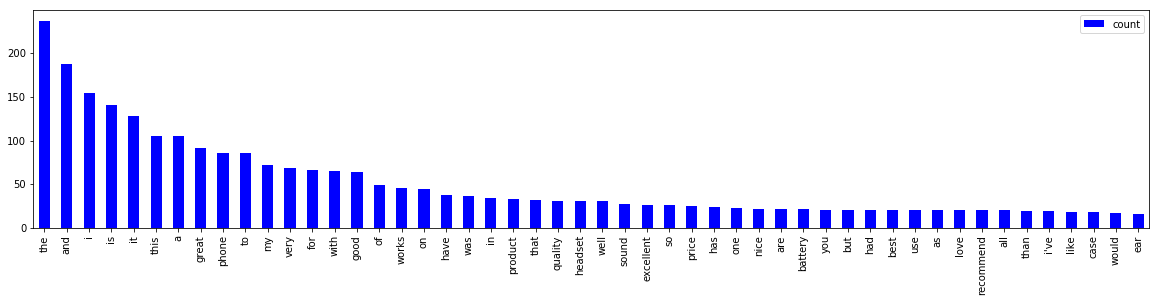

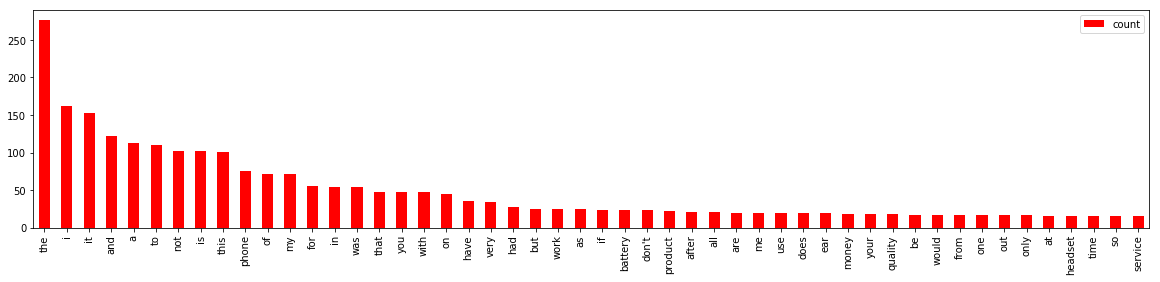

In [19]:
def freq_words(data):
    # Utilize dictionary: O(1) complexity
    freq_word_list = {}
    strings_dataframe = data.apply(lambda x: x.split())
    for strings in strings_dataframe:
        for string in strings:
            if string in freq_word_list:
                freq_word_list[str(string)] += 1
            else:
                freq_word_list[str(string)] = 1
    result = pd.DataFrame.from_dict(freq_word_list, orient='index')
    result.columns = ['count']
    return result

freq_word_pos = freq_words(df.loc[df.positive==1].text).sort_values('count', ascending=False)
freq_word_neg = freq_words(df.loc[df.positive==0].text).sort_values('count', ascending=False)

fig, axs = plt.subplots(figsize=(20,4))
freq_word_pos[:50].plot(kind='bar', ax=axs, color='b')
plt.show()

fig, axs = plt.subplots(figsize=(20,4))
freq_word_neg[:50].plot(kind='bar', ax=axs, color='r')
plt.show()

In [20]:
# Merge the two groups
freq_word_sum = freq_word_pos[:50].append(freq_word_neg[:50])
# Using 'groupby' to find the duplicated words in two groups
freq_word_sum_count = freq_word_sum.groupby(level=0).count()
freq_word_sum_count.columns = ['test']
keywords_new = list(freq_word_sum_count[freq_word_sum_count.test == 1].index)

In [37]:
keywords_new, len(keywords_new)

(['after',
  'at',
  'be',
  'best',
  'case',
  'does',
  "don't",
  'excellent',
  'from',
  'good',
  'great',
  'has',
  "i've",
  'if',
  'like',
  'love',
  'me',
  'money',
  'nice',
  'not',
  'only',
  'out',
  'price',
  'recommend',
  'service',
  'sound',
  'than',
  'time',
  'well',
  'work',
  'works',
  'your'],
 32)

Now! we are train the classifier with the new keywords.

In [22]:
df = df_orig.copy()
df.text = df_orig.text.apply(lambda x: featuring_text(x))
df = keyword_featuring(df, keywords_new)
df.head()

,text,positive,after,at,be,best,case,does,don't,excellent,...,price,recommend,service,sound,than,time,well,work,works,your
0,so there is no way for me to plug it in here i...,0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,good case excellent value,1,False,False,False,False,True,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2,great for the jawbone,1,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,tied to charger for conversations lasting more...,0,False,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,the mic is great,1,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [23]:
data = df[keywords_new]
target = df['positive']

In [24]:
scores = cross_val_score(clf, data, target, cv=10)
scores

array([ 0.85,  0.79,  0.81,  0.77,  0.79,  0.7 ,  0.73,  0.74,  0.77,  0.66])

In [25]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.76 (+/- 0.10)


GOOD!! It was improved around 8%.

In [26]:
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(clf,data,target,cv=10)
conf_mat = confusion_matrix(target,y_pred)

In [27]:
conf_mat

array([[438,  62],
       [177, 323]])

In [28]:
print('Sensitivity: ', conf_mat[1,1]/conf_mat[1,:].sum())
print('Specificity: ', conf_mat[0,0]/conf_mat[0,:].sum())

Sensitivity:  0.646
Specificity:  0.876


The accuracy and sensitivity with the new keywords seems improved!

### 3rd iteration!!!
I will combined the previous keywords and the new keywords!!

In [38]:
keywords_new2 = list(set(keywords + keywords_new))
keywords_new2, len(keywords_new2)

(['case',
  'me',
  'best',
  'only',
  'time',
  'love',
  'fine',
  'if',
  'price',
  'at',
  'your',
  'does',
  'impressed',
  'recommend',
  'money',
  'excellent',
  'sound',
  'than',
  'like',
  'be',
  'beautiful',
  'nice',
  'works',
  'good',
  'well',
  'from',
  "i've",
  'service',
  'after',
  'has',
  'easy',
  'work',
  'not',
  'great',
  "don't",
  'out'],
 36)

In [41]:
df = df_orig.copy()
df.text = df_orig.text.apply(lambda x: featuring_text(x))
df = keyword_featuring(df, keywords_new2)
df.head()

,text,positive,case,me,best,only,time,love,fine,if,...,i've,service,after,has,easy,work,not,great,don't,out
0,so there is no way for me to plug it in here i...,0,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,good case excellent value,1,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,great for the jawbone,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,tied to charger for conversations lasting more...,0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,the mic is great,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


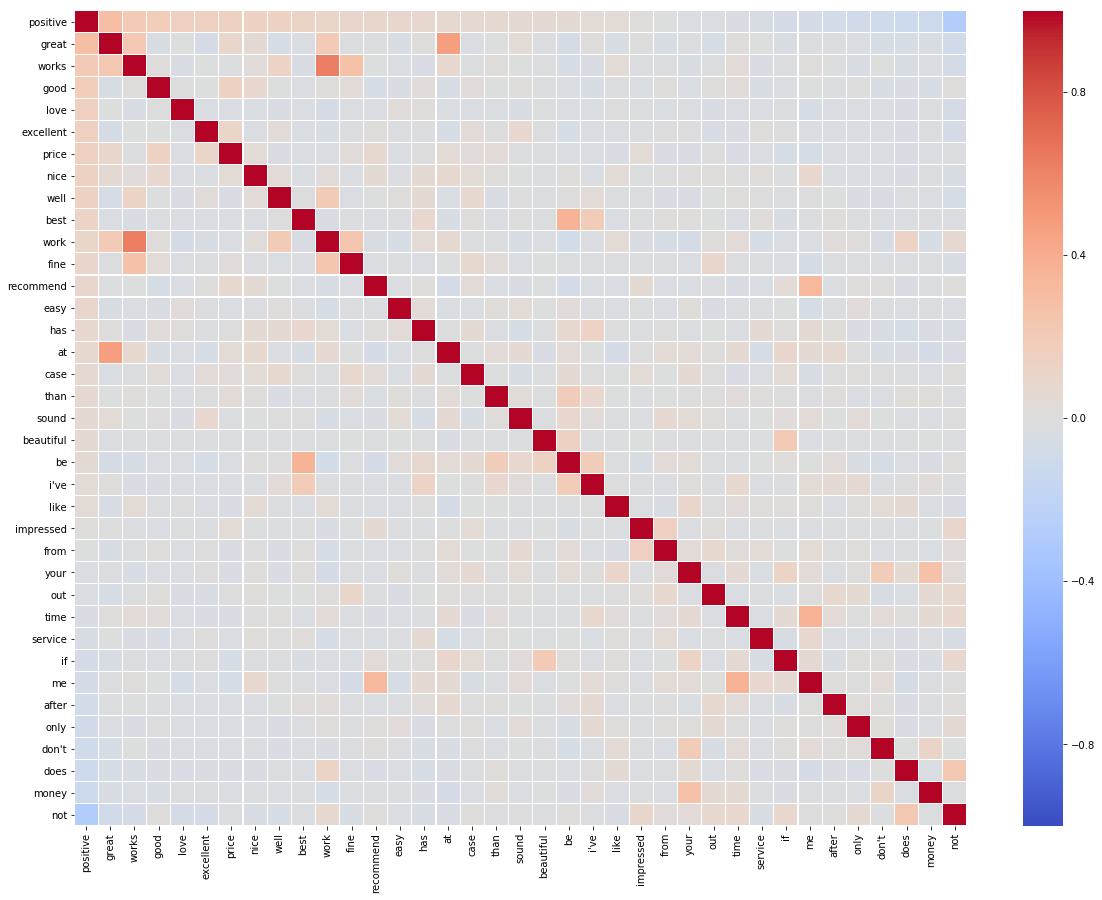

In [51]:
sort_corr_cols = list(df.corr()['positive'].sort_values(ascending=False).index)

plt.subplots(figsize=(20,15))
sns.heatmap(df[sort_corr_cols].corr(), cmap='coolwarm',  vmin = -1.0, vmax = 1.0, linewidths = 0.1)
plt.show()

In [42]:
data = df[keywords_new2]
target = df['positive']

In [43]:
scores = cross_val_score(clf, data, target, cv=10)
scores

array([ 0.86,  0.8 ,  0.81,  0.75,  0.82,  0.68,  0.76,  0.77,  0.77,  0.7 ])

In [44]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.77 (+/- 0.10)


Just 1% improved....

In [47]:
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(clf,data,target,cv=10)
conf_mat = confusion_matrix(target,y_pred)
conf_mat

array([[438,  62],
       [166, 334]])

In [48]:
print('Sensitivity: ', conf_mat[1,1]/conf_mat[1,:].sum())
print('Specificity: ', conf_mat[0,0]/conf_mat[0,:].sum())

Sensitivity:  0.668
Specificity:  0.876


The sensitivity seems slightly improved... hmmm. Let's try another type of feature except the word.